In [1]:
# %pip install -U langgraph langsmith
# %pip install -U "langchain[anthropic]"

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [3]:
import os
from langchain.chat_models import init_chat_model

# OpenAI
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("OPENAI_API_KEY is not set")
os.environ["OPENAI_API_KEY"] = api_key
llm = init_chat_model("openai:gpt-4.1")

# Tongyi
# from langchain_community.llms.tongyi import Tongyi
# llm = Tongyi()

# Anthropic
# import os
# api_key = os.getenv("ANTHROPIC_API_KEY")
# if api_key is None:
#     raise ValueError("ANTHROPIC_API_KEY is not set")
# os.environ["ANTHROPIC_API_KEY"] = api_key
# llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")



In [4]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")

In [6]:
graph_builder.add_edge("chatbot", END)

In [7]:
graph = graph_builder.compile()

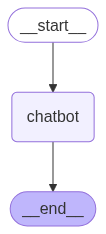

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}